In [1]:
%matplotlib inline

In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
from keras.applications.vgg16 import decode_predictions

C:\Users\kmura\AppData\Local\Programs\Python\Python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [39]:
model = VGG16(weights="imagenet")


# D:/SEM_7/Core_Project/visual-concepts/vtfq/

# img_path = 'image_vis.jpg'

img_path = 'D:/SEM_7/Core_Project/visual-concepts/vtfq/COCO_val2014_000000037615.jpg'
# img_path = 'C:/Users/kmura/Desktop/test_5.jpg'

# img_path = 'D:/SEM_7/Core_Project/visual-concepts/vtfq/COCO_val2014_000000001668.jpg' 
# best

# img_path = "D:/SEM_7/Core_Project/visual-concepts/vtfq/COCO_val2014_000000001869.jpg"

# img_path = "D:/SEM_7/Core_Project/visual-concepts/vtfq/COCO_val2014_000000115667.jpg"


img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [41]:
preds = model.predict(x)        # preds (1000,)
class_idx = np.argmax(preds[0]) # get class with highest probability


top_classes = preds[0].argsort()[-10:][::-1]
top_classes=top_classes.tolist()

class_idx = top_classes[0]

class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

In [42]:
# preds

In [43]:
# top_classes = preds[0].argsort()[-3:][::-1]

In [44]:
# top_classes=top_classes.tolist()

In [45]:
# preds[0][top_classes[0]]
# preds[0][top_classes[1]]
# preds[0][top_classes[2]]

In [46]:
label = decode_predictions(preds,top = 10)
label

[[('n03995372', 'power_drill', 0.19780894),
  ('n04317175', 'stethoscope', 0.113467604),
  ('n04482393', 'tricycle', 0.035689596),
  ('n04442312', 'toaster', 0.030177668),
  ('n03599486', 'jinrikisha', 0.028967576),
  ('n04517823', 'vacuum', 0.028553609),
  ('n03857828', 'oscilloscope', 0.027784258),
  ('n03425413', 'gas_pump', 0.027430737),
  ('n03630383', 'lab_coat', 0.023233399),
  ('n03000684', 'chain_saw', 0.0211833)]]

In [47]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
# Grads value is <tf.Tensor 'gradients_5/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>
# Calculates gradients for the layer (14,14,512) for each image passed.


pooled_grads = K.mean(grads, axis=(0, 1, 2))  

# Remember that we do this whole process for single image. So adding across 0 axis fine here. Now think of it as 512 matrices 
# of size (14,14), each matrix carrying the gradients (How important each element to the obj function. We take mean of 
# whole matrix (14,14), which carries importance as a whole to the final predictions. So you have 512 importance factors.

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# This line allows you to input an image and get pooled_grads (size (512) and these averaged gradients) 
# and last_conv_layer_output[0] (of size (14,14,512) and this
# are the actual filter weights not gradients)   

pooled_grads_value, conv_layer_output_value = iterate([x])
# Get the values.
# conv_layer_output_value.shape = (14, 14, 512)
# pooled_grads_value.shape = (512)

#Now take the channels of the image and multiply with the importance(pooled_gradient_value of that matrix) 
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [48]:
heatmap = np.mean(conv_layer_output_value, axis=-1)  # Adding each position at all layers(512) and dividing by |layers|
#Result is (14,14)

heatmap = np.maximum(heatmap, 0)  # Doing a ReLu

heatmap /= np.max(heatmap)  # Normalizing it to 0-1 range

In [49]:
# img = cv2.imread(img_path)  # Read the actual image

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Shape of heatmap is (img_rows,img_cols)
heatmap = np.uint8(255 * heatmap)  # conv 0-1 scale to 0-255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Colorize the image. (img_rows,img_cols) ==>(img_rows,img_cols,3)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0) # Weighted average (src[i]*alpha + hmap[i]*beta+gamma)



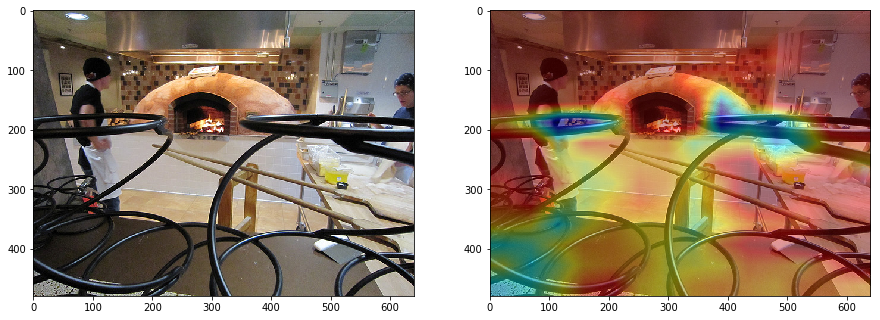

In [50]:
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(img)
axarr[1].imshow(superimposed_img)

